In [30]:
from common import NWSL, Colors, add_signature
from shapely.geometry import Point
import shapely.vectorized
import shapely.ops
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas
import itertools
import math

In [83]:
# all teams
#filename = "nearest_albers_2024_1.png"
#teams = ["KCC", "GFC", "ORL", "WAS", "LA", "BAY", "CHI", "HOU", "NC", "POR", "LOU", "SD", "RGN", "UTA"]
# quarterfinals
#filename = "nearest_albers_2024_2.png"
#teams = ["KCC", "GFC", "ORL", "WAS", "BAY", "CHI", "NC", "POR"]
# semifinals
#filename = "nearest_albers_2024_3.png"
#teams = ["KCC", "GFC", "ORL", "WAS"]
# finals
#filename = "nearest_albers_2024_4.png"
#teams = ["ORL", "WAS"]
# champion
filename = "nearest_albers_2024_5.png"
teams = ["ORL"]

In [84]:
df = pd.DataFrame(
    [
        ["LA", 34.013, -118.285],
        ["BAY", 37.351389, -121.925],
        ["CHI", 41.764722, -87.806111],
        ["HOU", 29.7522, -95.3524],
        ["KCC", 39.120333, -94.56625],
        ["GFC", 40.736667, -74.150278],
        ["NC", 35.786164, -78.755106],
        ["ORL", 28.5411, -81.3893],
        ["POR", 45.521389, -122.691667],
        ["LOU", 38.259444, -85.731944],
        ["SD", 32.784444, -117.122833],
        ["RGN", 47.5952, -122.3316],
        ["UTA", 40.5829, -111.8934],
        ["WAS", 38.868411, -77.012869],
    ],
    columns=["team", "lat", "long"],
)
df = df[df["team"].isin(teams)].reset_index(drop=True)

In [85]:
def hex_to_rgb(value):
    value = value.lstrip("#")
    lv = len(value)
    return tuple(int(value[i : i + lv // 3], 16) for i in range(0, lv, lv // 3))


df[["r", "g", "b"]] = pd.DataFrame(
    map(lambda t: hex_to_rgb(NWSL.color(t)), df["team"]),
    columns=["r", "g", "b"],
)
df

,team,lat,long,r,g,b
0,ORL,28.5411,-81.3893,96,38,158


In [86]:
# Convert city locations to projection coordinates
df["lat_alb"] = 0
df["long_alb"] = 0
for i, row in df.iterrows():
    point = Point((row["long"], row["lat"]))
    gdf = geopandas.GeoSeries([point], crs={"init": "epsg:4326"})
    new_point = gdf.to_crs("ESRI:102003")
    df.loc[i, "long_alb"] = new_point[0].x
    df.loc[i, "lat_alb"] = new_point[0].y

df

/home/agale/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,team,lat,long,r,g,b,lat_alb,long_alb
0,ORL,28.5411,-81.3893,96,38,158,-889085.209868,1.427429e+06


In [87]:
states = geopandas.read_file("data/usa-states-census-2014.shp")
alb_states = states["geometry"].to_crs("ESRI:102003")
alb_bounds = alb_states.bounds
alb_x_bounds = [min(alb_bounds["minx"]) - 1, max(alb_bounds["maxx"]) + 1]
alb_y_bounds = [min(alb_bounds["miny"]) - 1, max(alb_bounds["maxy"]) + 1]

In [88]:
# Create grid to fill in image
w = 1650
h = 951
grid = pd.DataFrame(itertools.product(range(0, w), range(0, h)), columns=["x", "y"])

In [89]:
# Convert pixels to albers coordinates
x_mult = (alb_x_bounds[1] - alb_x_bounds[0]) / w
y_mult = (alb_y_bounds[1] - alb_y_bounds[0]) / h

grid["long_alb"] = alb_x_bounds[0] + grid["x"] * x_mult + 0.02
grid["lat_alb"] = alb_y_bounds[0] + grid["y"] * y_mult + 0.03

In [90]:
# Calculate distance to each team
for i, row in df.iterrows():
    team = row["team"]
    lat1 = row["lat_alb"]
    long1 = row["long_alb"]
    grid[team] = (
        (grid["lat_alb"] - lat1).pow(2) + (grid["long_alb"] - long1).pow(2)
    ).pow(1.0 / 2)

In [91]:
# Calculate team with smallest distance
grid['closest'] = grid[df["team"]].idxmin(axis=1)
grid['distance'] = grid[df["team"]].min(axis=1)

In [92]:
# Calculate if points are outside the US
alb_country = shapely.ops.unary_union(alb_states)
grid["outside"] = ~shapely.vectorized.contains(
    alb_country, np.array(grid["long_alb"]), np.array(grid["lat_alb"])
)

In [93]:
# Calculate color of point
grid = pd.merge(grid, df, left_on="closest", right_on="team")
grid["a"] = (grid["distance"].mod(100000)) * 255 / 100000
grid.loc[grid["outside"], ["r", "g", "b", "a"]] = [255, 255, 255, 0]

In [94]:
# Convert to numpy 2D array
grid_im = np.zeros((h, w, 4), dtype=object)
grid_im[grid["y"], grid["x"], 0] = grid["r"]
grid_im[grid["y"], grid["x"], 1] = grid["g"]
grid_im[grid["y"], grid["x"], 2] = grid["b"]
grid_im[grid["y"], grid["x"], 3] = grid["a"]
grid_im = grid_im.astype("uint8")

/home/agale/.local/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 4000x4000 with 0 Axes>

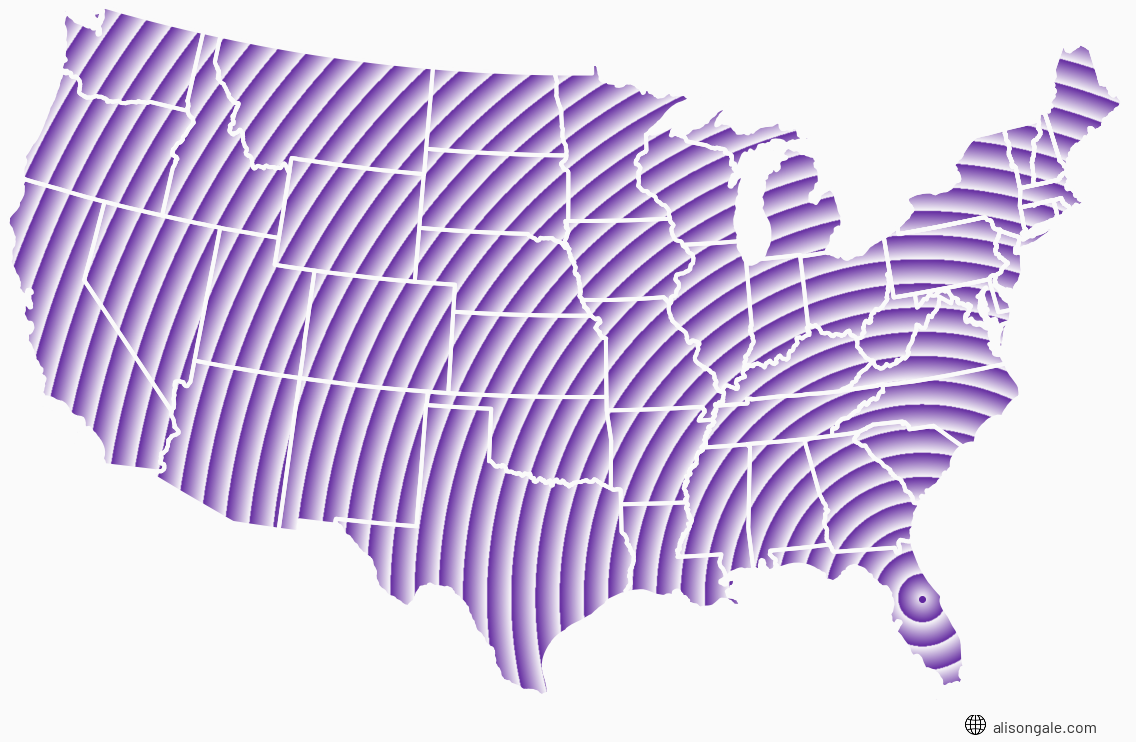

In [95]:
# Setup
plt.figure(dpi=200)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot concentric circles
ax.imshow(
    grid_im,
    extent=alb_x_bounds + alb_y_bounds,
    origin="lower",
    interpolation="gaussian",
)

# State outlines
states.boundary.to_crs("ESRI:102003").plot(ax=ax, color=Colors.WHITE, linewidth=4)

# Stadium locations
ax.scatter(df["long_alb"], df["lat_alb"], color=df["team"].apply(NWSL.color))

# Hide axis
ax.axis("off")

# Save image
add_signature(fig, x=0.79, y=0.24, fs=16, w=0.014)
plt.savefig(
    "images/" + filename,
    bbox_inches="tight",
    pad_inches=0.5,
    dpi=fig.dpi,
)